<center><h1>11. OPTICAL FLOW USING LUCAS KANADE AND KLT</h1></center>

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h1>1)Optical Flow Using Lucas Kanade Algorithm for two frames</h1>

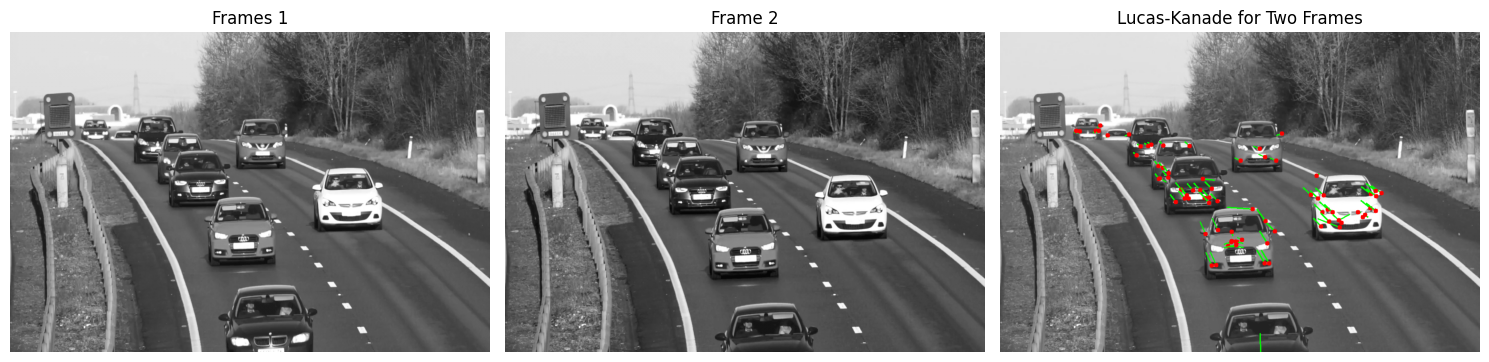

In [ ]:
# Load two consecutive frames
frame1 = cv2.imread(r'f1.png', cv2.IMREAD_GRAYSCALE) #Replace with your frame 1 path
frame2 = cv2.imread(r'f3.png', cv2.IMREAD_GRAYSCALE) #Replace with your frame 2 path

# Parameters for Lucas-Kanade optical flow
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

frame1 = cv2.resize(frame1,(1080,720))
frame2 = cv2.resize(frame2,(1080,720))

# Detect feature points in the first frame
p0 = cv2.goodFeaturesToTrack(frame1, mask=None, **feature_params)

# Calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, p0, None, **lk_params)

# Select good points
good_new = p1[st == 1]
good_old = p0[st == 1]

motion_threshold = 1.0
valid_points = np.linalg.norm(good_new-good_old, axis=1) > motion_threshold

good_new = good_new[valid_points]
good_old = good_old[valid_points]

# Draw the optical flow
output = cv2.cvtColor(frame2, cv2.COLOR_GRAY2BGR)
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(output, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    cv2.circle(output, (int(a), int(b)), 5, (0, 0, 255), -1)

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(frame1,cmap='gray')
plt.title('Frames 1')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(frame2,cmap='gray')
plt.title('Frame 2')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(output[:,:,::-1])
plt.title('Lucas-Kanade for Two Frames')
plt.axis('off')

plt.tight_layout()
plt.show()

<h1>2)Optical flow using Lucas Kanade Algorithm for video</h1>

In [ ]:
 # Load video
cap = cv2.VideoCapture(r"1.mp4")  # Replace with 0 for webcam
#Replace with your video path

# Parameters for feature detection
feature_params = dict(maxCorners=500, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame and convert to grayscale
ret, old_frame = cap.read()
if not ret:
    print("Error: Could not read video")
    cap.release()
    cv2.destroyAllWindows()
    exit()

old_frame = cv2.resize(old_frame, (1080, 720))  # Resize first frame
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)  # Detect features

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (1080, 720))  # Resize every frame
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow (Lucas-Kanade method)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw optical flow
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

        # Overlay mask on frame
        output = cv2.add(frame, mask)

        # Update previous frame and points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        # Re-detect feature points if too few remain
        if len(p0) < 50:
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            mask = np.zeros_like(frame)  # Reset mask to avoid clutter

    # Display the result
    cv2.imshow('Optical Flow - Lucas Kanade', output)

    if cv2.waitKey(30) & 0xFF == 27:  # Press 'ESC' to exit
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


<h1>3. KLT (KANADE-LUCAS TOMASI)</h1>

In [ ]:
video_path = r"3.mp4" #Replace with your video path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Cannot open video file {video_path}")
    exit()

frame_size = (1080, 720)

# KLT good features: only 1 corner
feature_params = dict(maxCorners=1, qualityLevel=0.3, minDistance=7, blockSize=7)

# Lucas-Kanade optical flow parameters
lk_params = dict(winSize=(15, 15), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read first frame
ret, old_frame = cap.read()
if not ret:
    print("Error reading first frame")
    cap.release()
    exit()

old_frame = cv2.resize(old_frame, frame_size)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect only the best single feature
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

mask = np.zeros_like(old_frame)
color = (0, 255, 0)  # Green trail

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, frame_size)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if p0 is not None:
        # Calculate optical flow for the current point
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is not None and st[0] == 1:
            a, b = p1[0].ravel()
            c, d = p0[0].ravel()

            # Draw trail and point
            mask = cv2.line(mask, (int(c), int(d)), (int(a), int(b)), color, 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, color, -1)

            # Update point
            p0 = p1
        else:
            print("Tracking lost. Reinitializing...")
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
            mask = np.zeros_like(old_frame)  # Reset trail

    old_gray = frame_gray.copy()

    output = cv2.add(frame, mask)
    cv2.imshow('KLT Single Good Feature Tracking', output)

    if cv2.waitKey(30) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


Tracking lost. Reinitializing...
Tracking lost. Reinitializing...
Tracking lost. Reinitializing...
Tracking lost. Reinitializing...
Tracking lost. Reinitializing...
Tracking lost. Reinitializing...
